# <center>What music do you like?</center>

Group S:      
* MB954931 Yang Jiaqi
* MB955283 Chen Yuanyuan
* MB955398 Long Long

# Collect Data

Our datasets are consisted of data collected from website and documents downloaded from data.world and kaggle. By using the Python API **billboard.py** which is shared in [GitHub](https://github.com/guoguo12/billboard-charts), we can access to [Billboard.com](https://www.billboard.com/charts) to scratch music charts. 

By the way, since there is authority limitation for scratching data from Billboard, we need to limit the speed of scratching. It is the package **ratelimiter.py** that helps us control the time and speed successfully. 



In [1]:
pip install billboard.py

Note: you may need to restart the kernel to use updated packages.


In [2]:
import billboard
billboard.charts()# The kinds of music charts we can obtain from Billboard

['hot-100',
 'billboard-200',
 'artist-100',
 'social-50',
 'streaming-songs',
 'radio-songs',
 'digital-song-sales',
 'on-demand-songs',
 'top-album-sales',
 'current-albums',
 'catalog-albums',
 'independent-albums',
 'soundtracks',
 'vinyl-albums',
 'greatest-of-all-time-artists',
 'greatest-billboard-200-albums',
 'greatest-billboard-200-artists',
 'greatest-hot-100-singles',
 'greatest-hot-100-artists',
 'greatest-hot-100-songs-by-women',
 'greatest-hot-100-women-artists',
 'greatest-billboard-200-albums-by-women',
 'greatest-billboard-200-women-artists',
 'greatest-billboards-top-songs-80s',
 'greatest-billboards-top-songs-90s',
 'greatest-of-all-time-pop-songs',
 'greatest-of-all-time-pop-songs-artists',
 'greatest-adult-pop-songs',
 'greatest-adult-pop-artists',
 'greatest-country-songs',
 'greatest-country-albums',
 'greatest-country-artists',
 'greatest-hot-latin-songs',
 'greatest-hot-latin-songs-artists',
 'greatest-top-dance-club-artists',
 'greatest-r-b-hip-hop-songs',
 '

In [3]:
pip install ratelimiter

Note: you may need to restart the kernel to use updated packages.


In [4]:
import datetime
from ratelimiter import RateLimiter
#After trying many times, we find that visiting the URL 2 times per 15 seconds is the best-balanced frequency that would not lead to "Too Many Request".
ratelimit = RateLimiter(max_calls=2, period=15) 
outfilename = 'hot_100.psv'
counter = 2    # how many weeks of music charts we want to scratch
chart_type = 'hot-100'
chart_date = '2019-12-07'  
chart = billboard.ChartData(chart_type, chart_date)

first_line = 'date | title | artist | weeks | current | peak | previous\n'

# Write data into files
with open(outfilename, 'a') as outputfile:
    outputfile.write(first_line)
 
for i in range (counter):
    with ratelimit:
        for song in chart:
            line_out = str(str(chart_date) + ' | ' + str(song.title) + ' | ' + str(song.artist) + ' | ' + str(song.weeks)  + ' | ' + str(song.rank) + ' | ' + str(song.peakPos) + ' | ' + str(song.lastPos) + '\n')
            with open(outfilename, 'a',encoding='utf-8') as outputfile:
                outputfile.write(line_out)
        print(chart_date)
        print(chart[0])
        chart_date = chart.previousDate 
        chart = billboard.ChartData(chart_type, chart.previousDate)
print('done')

2019-12-07
'Circles' by Post Malone
2019-11-30
'Circles' by Post Malone
done


We write the data scratched from Billboard to files like this:
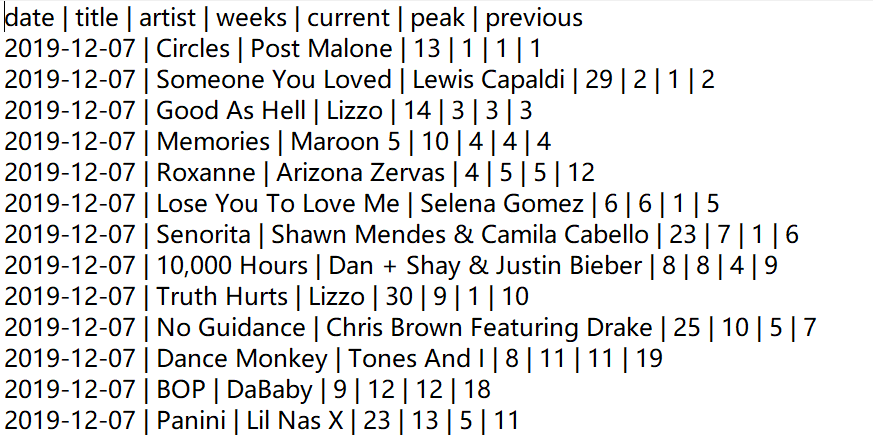

We totally collected 10 music charts from Billboard.
* hot-100           
* artist-100         
* pop-songs        
* country-songs       
* rock-songs        
* r-b-hip-hop-songs   
* dance-electronic-songs   
* japan-hot-100   
* k-pop-hot-100   
* billboard-china-social-chart 

# Clean Data

Here, we only take chart hot-100 as example to show how we clean data. Other charts were cleaned up through similar process and saved to csv files. In the following processes of data process and data visualization, we directly import those files to achieve our data analysis.

Every chart we scratch from Billboard has 7 attributes.
* **date** : the charts generate tracks week by week
* **title** : the titles of tracks
* **artist** : the name of the artist, as formatted on Billboard.com
* **weeks** : the number of weeks the track has been or was on the chart, including future dates (up until the present time)

* **current** : the track's current position on the chart
* **peak** : the track's peak position on the chart at any point in time, including future dates, as an int (or None if the chart does not include this information)
* **previous** : the track's position on the previous week's chart, as an int (or None if the chart does not include this information). This value is 0 if the track was not on the previous week's chart

In [5]:
import pandas as pd
from pandas import DataFrame

hot100=pd.read_csv('hot_100.psv',sep='|')
hot100.columns=['date','title','artist','weeks','current','peak','previous']
hot100.head()

,date,title,artist,weeks,current,peak,previous
0,2019-12-07,Circles,Post Malone,13,1,1,1
1,2019-12-07,Someone You Loved,Lewis Capaldi,29,2,1,2
2,2019-12-07,Good As Hell,Lizzo,14,3,3,3
3,2019-12-07,Memories,Maroon 5,10,4,4,4
4,2019-12-07,Roxanne,Arizona Zervas,4,5,5,12


In [7]:
# Strip blank spaces from the beginning and end of string
hot100['title']=hot100['title'].str.strip(to_strip=None)
hot100['artist']=hot100['artist'].str.strip(to_strip=None)
# Transform the type of date from string to datetime
hot100['date']=pd.to_datetime(hot100['date'])

# Change the type of data in column peak from object to int
hot100['peak'] = hot100['peak'].replace(' None ',0)
hot100['peak'] = hot100['peak'].apply(lambda x: int(x), list(hot100.peak))

# Define a split_artist function to preserve only lead singer of those jointly performed songs
def split_artist(x):
    locat = x.find("eaturing")
    if locat == -1:
        return x
    else:
        return x[0:locat-2]

hot100['artist']=hot100['artist'].apply(split_artist)

# Export dataframe to csv files
hot100.to_csv('hot100.csv')

# Data Process & Data Visualization



**Trend of Music Genre From 1958 to 2019**

To see the trend of the number of each style of music in hot-100 chart from 1958 to 2019, we need to merge the charts then categorize songs to different types in table hot-100. 

In [8]:
hot=pd.read_csv('hot-100.csv')

cs=pd.read_csv('country-songs.csv')
cs_title=list(set(cs.title))# Firstly, we pick out columns 'title' from the five different types music charts
cs_type=DataFrame(cs_title,columns=['title'])# Then create a new dataframe to save the column 'title'
cs_type['type']='country song'# In this new dataframe, we create a new column named 'type' which is used to describe the type of songs
a=pd.merge(hot,cs_type,on='title',how='left')# Merge the new dataframe with chart hot-100, so that we know the type of songs in it

# The same process for the other four charts
de=pd.read_csv('dance-electronic-songs.csv')
de_title=list(set(de.title))
de_type=DataFrame(de_title,columns=['title'])
de_type['type']='dance electronic'
b=pd.merge(a,de_type,on='title',how='left')

pp=pd.read_csv('pop-songs.csv')
pp_title=list(set(pp.title))
pp_type=DataFrame(pp_title,columns=['title'])
pp_type['type']='pop'
c=pd.merge(b,pp_type,on='title',how='left')

hp=pd.read_csv('rbhiphop.csv',encoding='ISO-8859-1')
hp_title=list(set(hp.title))
hp_type=DataFrame(hp_title,columns=['title'])
hp_type['type']='r&b/hiphop'
d=pd.merge(c,hp_type,on='title',how='left')

rs=pd.read_csv('rock-songs.csv',encoding='ISO-8859-1')
rs_title=list(set(rs.title))
rs_type=DataFrame(rs_title,columns=['title'])
rs_type['type']='rock song'
e=pd.merge(d,rs_type,on='title',how='left')

e.columns=['date','title','artist','weeks','current','peak','previous','country song','dance electronic','pop','r&b/hiphop','rock']
e.date=pd.to_datetime(e.date)
e=e.set_index('date')
e['year']=e.index.year
e.head()

,title,artist,weeks,current,peak,previous,country song,dance electronic,pop,r&b/hiphop,rock,year
date,,,,,,,,,,,,
2019-12-14,Heartless,The Weeknd,2,1,1,32,country song,NaN,pop,r&b/hiphop,rock song,2019
2019-12-14,Circles,Post Malone,14,2,1,1,country song,dance electronic,pop,r&b/hiphop,rock song,2019
2019-12-14,All I Want For Christmas Is You,Mariah Carey,34,3,3,18,country song,NaN,pop,NaN,NaN,2019
2019-12-14,Someone You Loved,Lewis Capaldi,30,4,1,2,NaN,NaN,pop,NaN,NaN,2019
2019-12-14,Memories,Maroon 5,11,5,4,4,NaN,NaN,pop,NaN,rock song,2019


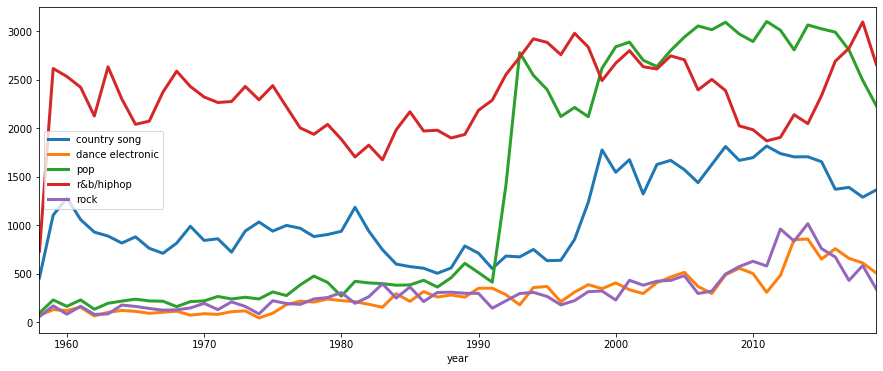

In [13]:
import numpy as np
import matplotlib.pyplot as plt
e.groupby(['year'])['country song','dance electronic','pop','r&b/hiphop','rock'].count().plot(figsize=(15,6),linewidth=3)
plt.savefig('line.jpg')
plt.show()


**Percentage Changes of Music Genre for Diverse Eras**

We take 10 years as a group and use the stacked bar chart to clearly demonstrate the changes of percnetages of five genres over 60 years. 

In [14]:
# Separate tracks into 6 groups each 10 years by using concat()
y_2010s=pd.concat([e[e['year']==2019],e[e['year']==2018],e[e['year']==2017],e[e['year']==2016],e[e['year']==2015],
                 e[e['year']==2014],e[e['year']==2013],e[e['year']==2012],e[e['year']==2011],e[e['year']==2010]],axis=0)
y_2000s=pd.concat([e[e['year']==2009],e[e['year']==2008],e[e['year']==2007],e[e['year']==2006],e[e['year']==2005],
                 e[e['year']==2004],e[e['year']==2003],e[e['year']==2002],e[e['year']==2001],e[e['year']==2000]],axis=0)
y_1990s=pd.concat([e[e['year']==1999],e[e['year']==1998],e[e['year']==1997],e[e['year']==1996],e[e['year']==1995],
                 e[e['year']==1994],e[e['year']==1993],e[e['year']==1992],e[e['year']==1991],e[e['year']==1990]],axis=0)
y_1980s=pd.concat([e[e['year']==1989],e[e['year']==1988],e[e['year']==1987],e[e['year']==1986],e[e['year']==1985],
                 e[e['year']==1984],e[e['year']==1983],e[e['year']==1982],e[e['year']==1981],e[e['year']==1980]],axis=0)
y_1970s=pd.concat([e[e['year']==1979],e[e['year']==1978],e[e['year']==1977],e[e['year']==1976],e[e['year']==1975],
                 e[e['year']==1974],e[e['year']==1973],e[e['year']==1972],e[e['year']==1971],e[e['year']==1970]],axis=0)
y_1960s=pd.concat([e[e['year']==1969],e[e['year']==1968],e[e['year']==1967],e[e['year']==1966],e[e['year']==1965],
                 e[e['year']==1964],e[e['year']==1963],e[e['year']==1962],e[e['year']==1961],e[e['year']==1960]],axis=0)
# Create lists used for saving the percentages of each type of songs in its own group
count_2010=[]
count_2000=[]
count_1990=[]
count_1980=[]
count_1970=[]
count_1960=[]

# Calculate the proportion of each tpye of songs in groups
count_2010.append(len(y_2010s[y_2010s['country song']=='country song']))
count_2010.append(len(y_2010s[y_2010s['dance electronic']=='dance electronic']))
count_2010.append(len(y_2010s[y_2010s['pop']=='pop']))
count_2010.append(len(y_2010s[y_2010s['r&b/hiphop']=='r&b/hiphop']))
count_2010.append(len(y_2010s[y_2010s['rock']=='rock song']))
sum_2010=sum(count_2010)
for i in range(5):
    count_2010[i]=count_2010[i]/sum_2010
print(count_2010)

count_2000.append(len(y_2000s[y_2000s['country song']=='country song']))
count_2000.append(len(y_2000s[y_2000s['dance electronic']=='dance electronic']))
count_2000.append(len(y_2000s[y_2000s['pop']=='pop']))
count_2000.append(len(y_2000s[y_2000s['r&b/hiphop']=='r&b/hiphop']))
count_2000.append(len(y_2000s[y_2000s['rock']=='rock song']))
sum_2000=sum(count_2000)
for i in range(5):
    count_2000[i]=count_2000[i]/sum_2000
print(count_2000)

count_1990.append(len(y_1990s[y_1990s['country song']=='country song']))
count_1990.append(len(y_1990s[y_1990s['dance electronic']=='dance electronic']))
count_1990.append(len(y_1990s[y_1990s['pop']=='pop']))
count_1990.append(len(y_1990s[y_1990s['r&b/hiphop']=='r&b/hiphop']))
count_1990.append(len(y_1990s[y_1990s['rock']=='rock song']))
sum_1990=sum(count_1990)
for i in range(5):
    count_1990[i]=count_1990[i]/sum_1990
print(count_1990)

count_1980.append(len(y_1980s[y_1980s['country song']=='country song']))
count_1980.append(len(y_1980s[y_1980s['dance electronic']=='dance electronic']))
count_1980.append(len(y_1980s[y_1980s['pop']=='pop']))
count_1980.append(len(y_1980s[y_1980s['r&b/hiphop']=='r&b/hiphop']))
count_1980.append(len(y_1980s[y_1980s['rock']=='rock song']))
sum_1980=sum(count_1980)
for i in range(5):
    count_1980[i]=count_1980[i]/sum_1980
print(count_1980)

count_1970.append(len(y_1970s[y_1970s['country song']=='country song']))
count_1970.append(len(y_1970s[y_1970s['dance electronic']=='dance electronic']))
count_1970.append(len(y_1970s[y_1970s['pop']=='pop']))
count_1970.append(len(y_1970s[y_1970s['r&b/hiphop']=='r&b/hiphop']))
count_1970.append(len(y_1970s[y_1970s['rock']=='rock song']))
sum_1970=sum(count_1970)
for i in range(5):
    count_1970[i]=count_1970[i]/sum_1970
print(count_1970)

count_1960.append(len(y_1960s[y_1960s['country song']=='country song']))
count_1960.append(len(y_1960s[y_1960s['dance electronic']=='dance electronic']))
count_1960.append(len(y_1960s[y_1960s['pop']=='pop']))
count_1960.append(len(y_1960s[y_1960s['r&b/hiphop']=='r&b/hiphop']))
count_1960.append(len(y_1960s[y_1960s['rock']=='rock song']))
sum_1960=sum(count_1960)
for i in range(5):
    count_1960[i]=count_1960[i]/sum_1960
print(count_1960)

[0.19494558016864574, 0.07667067024925397, 0.35219970035041664, 0.29182402397196666, 0.08436002525971695]
[0.20306737543556222, 0.05262354706615459, 0.3683139608820612, 0.32426176971793375, 0.05173334689828827]
[0.14187917450905274, 0.05243433216183353, 0.3189199993337442, 0.44390958908672984, 0.04285690490863967]
[0.20620051299208209, 0.06693989071038252, 0.11500501840080295, 0.5309468049514888, 0.08090777294524368]
[0.2415019238423776, 0.03656627305293884, 0.08183627437972668, 0.5902613772057848, 0.04983415151917209]
[0.2468195446074062, 0.028603840855684303, 0.05377738162763687, 0.6357669556762012, 0.035032277233071334]


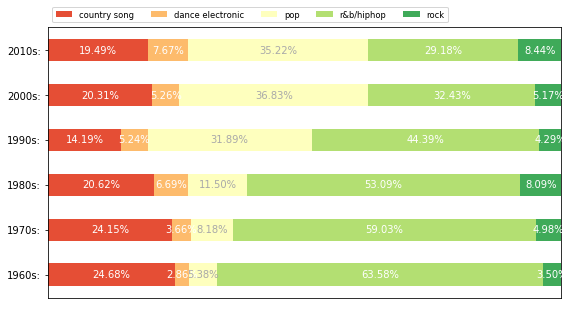

In [15]:
type_name=['country song','dance electronic','pop','r&b/hiphop','rock']
results={'2010s:':count_2010,'2000s:':count_2000,'1990s:':count_1990,'1980s:':count_1980,'1970s:':count_1970,'1960s:':count_1960}

def stacked_bar(results, type_name):
    labels=list(results.keys())
    data=np.array(list(results.values()))
    data_cum=data.cumsum(axis=1)
    category_colors=plt.get_cmap('RdYlGn')(np.linspace(0.15,0.85,data.shape[1]))
    fig,ax=plt.subplots(figsize=(9.2,5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0,np.sum(data,axis=1).max())
    for i,(colname,color) in enumerate(zip(type_name,category_colors)):
        widths=data[:,i]
        starts=data_cum[:,i]-widths
        ax.barh(labels,widths,left=starts,height=0.5,label=colname,color=color)
        xcenters=starts+widths/2
        r,g,b,_=color
        text_color='white' if r*g*b<0.5 else 'darkgrey'
        for y,(x,c) in enumerate(zip(xcenters,widths)):
            ax.text(x,y,str(format(c*100, '.2f')+'%'),ha='center',va='center',color=text_color)
    
    ax.legend(ncol=len(type_name),bbox_to_anchor=(0,1),loc='lower left',fontsize='small')
    
    return fig,ax

stacked_bar(results,type_name)
plt.savefig('stacked bar.jpg')
plt.show()


From both charts above, we can conclude that from 1958 to 2019 r&b/hiphop style music are always popular, rock songs and dance electronic songs both keep stable. There is a surprising discovery that from the beginning of 1990s, the amount of people who liked to listen to pop music had a sharply climb from 5.38% to 35.22%.

**Which Song Is Always the No.1**

We also want to see which song has kept the longest-term popularity. So we need to pick out all songs which have been at 'the king seat' and calculate how many weeks they stayed in top 1 position. In the bar chart below, it is obvious that the song *Old Town Road* has been the most famous song for nearly 20 weeks.

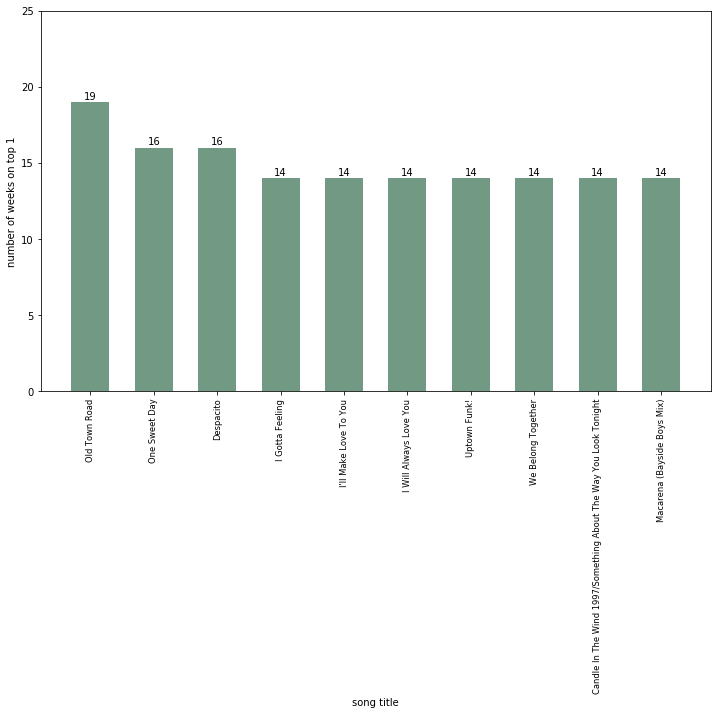

In [16]:
hot_1=hot[hot['current']==1].groupby(['title'])['current'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,7))
plt.ylim(0,25)

plt.xlabel('song title')
plt.ylabel('number of weeks on top 1')
x=np.arange(10)+1
y=np.array(list(hot_1.values))
xticks1=list(hot_1.index)
plt.bar(x,y,width=0.6,align='center',color=(0.3,0.5,0.4,0.6),alpha=0.8)
plt.xticks(x,xticks1,size='small',rotation=90)

for a,b in zip(x,y):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.savefig('bar.jpg')
plt.show()


**Who Is the Hottest Artist**

To understand the singer who ran after by the most of music-lovers, we use the chart "artist-100", which lists the top 100 popular singers over weeks, to generate a barchart to show the results.

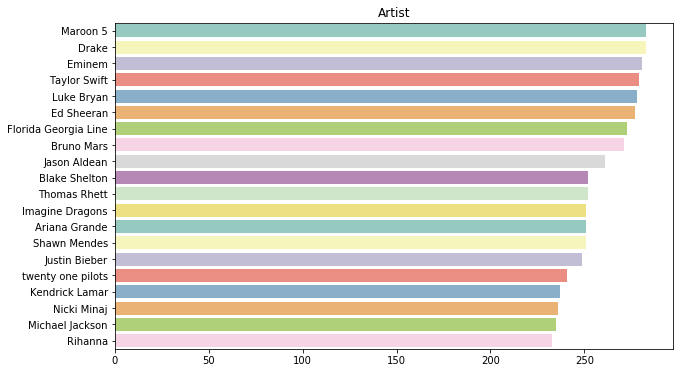

In [17]:
import seaborn as sns

art = pd.read_csv('artist-100.csv')
art.date = pd.to_datetime(art.date)
frq = art.groupby("artist")['weeks'].max() 
fbar = frq.sort_values(ascending=False).head(20)

dic = dict(fbar)
singer = list(dic.keys())
popu = list(dic.values())

plt.figure(figsize=(10,6)) # Size of chart
plt.title('Artist') 
plt.yticks(size=10)
sns.barplot(popu,singer,palette='Set3')
plt.savefig('art_bar.jpg')

As shown in the chart above, it is obviously that the top three singers are in a fierce competition that the differences between their popularity are slight. And Maroon 5 is the "king" right now. Let's see how long would he stay in the seat.

**Music Features of Top 5 Artists**

Here we use another datafile named "Hot 100 Audio Features" in which there are features data of Hot 100 songs.
We then use spider chart to demonstrate the song features of the top 5 hottest artists we concluded above.

In [18]:
from math import pi

feature = pd.read_excel('Hot 100 Audio Features.xlsx')

# Create a function to build list of artists's music features by computing the means
def get_features(artist):
    fe = feature[feature['SongID'].str.find(artist)!=-1]
    da = fe.danceability.mean()
    en = fe.energy.mean()
    inst = fe. instrumentalness.mean()
    live = fe.liveness.mean()
    spee = fe.speechiness.mean()
    vale = fe.valence.mean()
    acou = fe.acousticness.mean()
    L = [artist,da,en,inst,live,spee,vale,acou]
    return L

af = np.array([get_features('Maroon 5'),
               get_features('Drake'),
               get_features('Eminem'),
               get_features('Taylor Swift'),
               get_features('Luke Bryan')])

df = pd.DataFrame(af)
df.columns=['artist','danceability','energy','instrumentalness','liveness','speechiness','valence','acousticness']

# Change the type of numbers
df['danceability'] = df['danceability'].astype('float64')
df['energy'] = df['energy'].astype('float64')
df['instrumentalness'] = df['instrumentalness'].astype('float64')
df['liveness'] = df['liveness'].astype('float64')
df['speechiness'] = df['speechiness'].astype('float64')
df['valence'] = df['valence'].astype('float64')
df['acousticness'] = df['acousticness'].astype('float64')

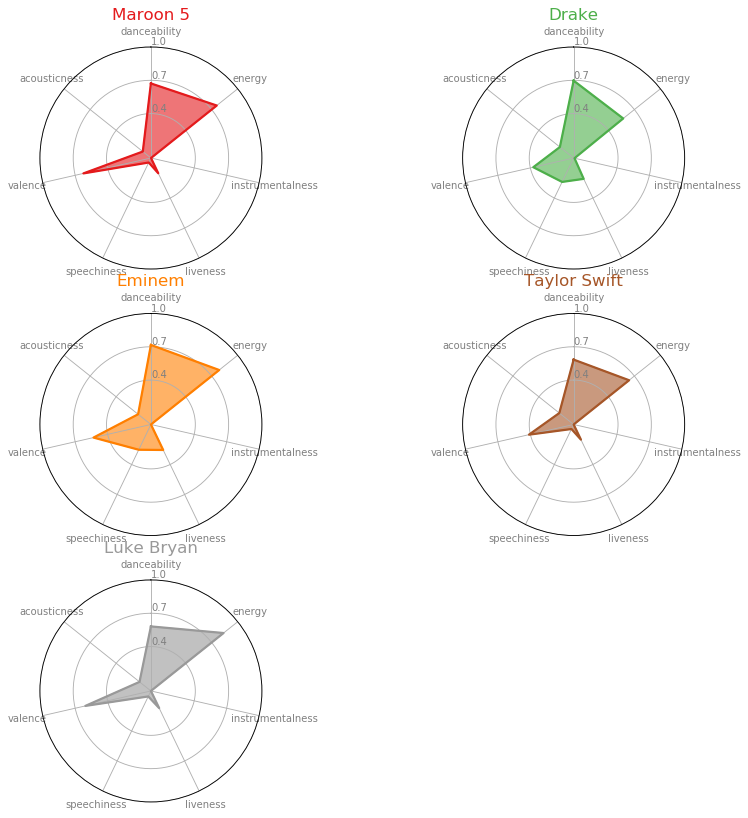

In [19]:
#define a function to creat a series of spider charts
def make_spider(row,title,color):
    categories = list(df)[1:]
    N = len(categories)
    
    angles = [n/float(N)*2*pi for n in range(N)]
    angles += angles[:1]
    
    ax = plt.subplot(3,2,row+1, polar=True)
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, color='grey', size=9)
    
    ax.set_rlabel_position(0)
    plt.yticks([0.4,0.7,1.0],['0.4','0.7','1.0'], color='grey', size=9)
    plt.ylim(0,1)
    
    values = df.loc[row].drop('artist').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.6)
    
    plt.title(title, size=15, color=color, y=1)

my_dpi=80
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi),dpi=my_dpi)

my_palette = plt.cm.get_cmap('Set1', len(df.index))

for row in range(len(df.index)):
    make_spider(row=row, title=df['artist'][row],color=my_palette(row))
plt.savefig('spider.jpg')
plt.show()

**Interpretation**

The five artists used in this example are who had their songs on chart The Hot 100 for longest time, which means they are very popular. By loooking at these spider charts, we can see that they have similar shapes and the features of these popular artists's production do not differ much. To be specific, songs with higher dancability and energy would be more popular.

**Features Defination**
 
 1. **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
 2. **Acousticness**: A measure from 0.0 to 1.0 of whether the track is acoustic.
 3. **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

 4. **Instrumentalness**: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
 5. **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

 6. **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
 7. **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
 

**What People Mostly Frequently Express by Songs**

Kaggle provides us the lyric datas, including different languages top songs liked by people. To see the situaton of English songs, we filter the chart and made a wordcloud with the help of the librery WordCloud.

In [20]:
lyric = pd.read_csv('lyrics-data.csv')
lyric.drop(['ALink'],axis=1,inplace=True)
lyric.drop(['SLink'],axis=1,inplace=True)
# Pick English lyrics out and save into a list
en = lyric[lyric['Idiom'] == 'ENGLISH'].Lyric
ent = list(en.values)

# Write English lyrics of list ent into txt file
enoutput = open('entxt.txt','w',encoding='utf-8')
for i in range(len(ent)):
        enoutput.write(str(ent[i])) 
enoutput.close()

filename = "entxt.txt"
with open(filename,encoding="utf-8") as f:
    eng = f.read()

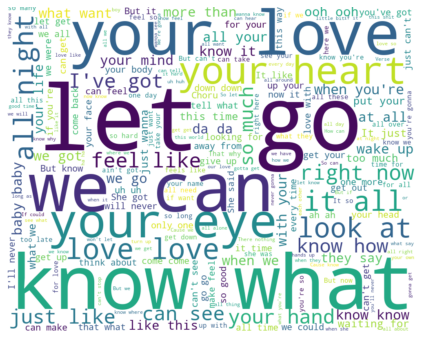

In [22]:
from wordcloud import WordCloud

encloud = WordCloud(width=1000,height=800,margin=1,
                    stopwords = ['hey','oh','the','in','to','you','it','la','that','on','and','is','yeah','And','my','me','na','not','do','no','there','been','ve','be',"don\'t",'are',"I'm",'of'],
                    background_color='white').generate(eng) # Filter out a set of meaningless words
plt.figure(figsize=(10,6))
plt.imshow(encloud, interpolation='bilinear')
plt.axis("off")
encloud.to_file('cloud.jpg')